# Stepnarrowband.py Notebook

Cloonan, Kasinath, Mahns, Willard

Tentatively named. Will be copied over to a .py file once completed.

In this notebook, we have attempted to write a step to be added to the pipeline that uses the [drizzle](https://spacetelescope.github.io/drizzle/drizzle/user.html#the-drizzle-algorithm) package to align a narrowband image to a baseline broadband image, remove the baseline image, and use the result as a WCS solution for the narrowband image.

Links from 3/4:

https://stars.uchicago.edu/queue/data/Berthoud/examples
https://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html
https://docs.astropy.org/en/stable/wcs/

Try astroalign?
Try a blurring method to find

Look at Dr. Harper's align image notebook. put in a threshold and it goes looking for patches. it calculates the first moment.

The displacement shouldn't be so large that magnification differences become a problem.

Bring all of this to the group's attention.

In [1]:
! pip install configobj
! pip install ccdproc # Not needed for Coadd
#! pip install lmfit # Not needed for Coadd
! pip install linalg
! pip install drizzle
! pip install darepype
! pip install SEP

! pip install astroalign

  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=60281b12e7dbcc58b34eccd50f286eaef8d35194afff8dc40d83e5aed19adc00
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj
     |████████████████████████████████| 614kB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 450kB 14.5MB/s 
     |████████████████████████████████| 1.3MB 23.3MB/s 
     |████████████████████████████████| 215kB 45.2MB/s 
  Created wheel for ccdproc: filename=ccdproc-2.1.1-cp37-none-any.whl size=354040 sha256=184631dae5e8657c56a158ae37edc04feb84569eb774073dbdcc91a1fb19c8bc
  Stored in directory: /root/.cache/pip/wheels/29/04/f4/a1c6d90dd0f62eb13e65e72d737570f939d432c9a21ff2c6a5
Successfully built ccdproc
  Created wheel for astroscrappy: filename=astroscrappy-1.0.8-cp37-cp3

In [2]:
### Install SEO pipeline - and go to correct branch

import sys

# Location where the code is
codefolder = '/content'

# Clone the project from github
import os
os.chdir(codefolder)
!git clone https://github.com/yerkesobservatory/pipeline.git
# If you want to checkout a different branch
os.chdir('pipeline')
#!git checkout darepype
!git pull
# Set the Path
sys.path.append(os.path.join(codefolder,'pipeline/source'))
print('Instaled SEO pipeline')

Cloning into 'pipeline'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 2016 (delta 106), reused 121 (delta 46), pack-reused 1827
Receiving objects: 100% (2016/2016), 71.60 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (1246/1246), done.
Already up to date.
Instaled SEO pipeline


In [6]:
## Copied from Dr. Harper's image_combine_3.ipynb

## Imports and system path additions. This contains some imports not required for this notebook. 

import os
import numpy as np                                # numpy is a collection of python modules for array math.
from matplotlib import pyplot as plt              # A collection of modules. Needed here to display images and graphs.
from matplotlib import pylab                      # A collection of modules. Needed here to plot histograms.
#sys.path.append('/Users/alex/mycode/a212pylibs') # Adds the path to the DataPype module to the system path.
from darepype.drp.datafits import DataFits            # Gets the function that makes datapype io objects from module datafits in package datapype.
from astropy.io import fits                       # Need this if you want to use astropy.io io objects.
from ipywidgets import interact                   # Need this for interactive plots.
from matplotlib.colors import LogNorm             # Machinery for LogNorm scaling of intensities.
from matplotlib.colors import SymLogNorm          # Machinery for SymLogNorm scaling of intensities.
from matplotlib.colors import PowerNorm           # Machinery for LogNorm (e.g., square root) scaling of intensities.
from astropy.stats import mad_std                 # The median absolute deviation, a more robust estimator than std.
from astropy.time import Time
from astropy.table import Table
import scipy.ndimage as nd                        # Various algorithms for image transformations.
import scipy.signal
from astropy import wcs

import requests
import re

import astroalign as aa


### File Definitions: HERE YOU NEED TO SPECIFY WHICH FILES / FOLDERS YOU WANT TO USE
import os
# Source to download / get the RAW files from
urlpath = 'https://stars.uchicago.edu/images/StoneEdge/0.5meter/2021/2021-02-16/itzamna/'
filenames = ['NGC2403_g-band_60s_bin2_210216_074810_itzamna_seo_0_WCS.fits',
             'NGC2403_h-alpha_120s_bin2_210216_062520_itzamna_seo_0_RAW.fits']

# Location where you want the logfile
logfilename = '/content/pipelog.txt'

# Location where you want the data to be
datafolder = '/content/data'
# Location of config files
baseconfig = os.path.join(codefolder,'pipeline/config','pipeconf_SEO.txt')

# Location where you want the logfile
logfilename = '/content/pipelog.txt'
# Location where the code is
codefolder = '/content'
# Location where you want the data to be
datafolder = '/content/data'

### Load the images from the web.
#   WARNING: If you get ANY error messages here, please check your URLS and try again.
# Make the data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
fileurls = [os.path.join(urlpath,f) for f in filenames]
infilenames = [os.path.join(datafolder,f) for f in filenames]
for ind in range(len(filenames)):
    #filedata = urllib.urlretrieve(fileurls[ind],infilenames[ind]) # python 2
    #filedata = urllib.request.urlretrieve(fileurls[ind],infilenames[ind]) # python 3
    resp = requests.get(fileurls[ind],verify=False)
    open(infilenames[ind],'wb').write(resp.content)
print("Loaded files:\n%s" % '\n'.join(filenames))

def open_seo_fits(file):
    file_hdu = fits.open(file)
    # i think seo fits hdus have only the one index
    data = file_hdu[0].data
    header = file_hdu[0].header 
    file_hdu.close()
    return data, header

broad  = infilenames[0];
narrow = infilenames[1]
print(broad)

## Make a mask for values in the image less than some value.
## Replace values less than the limit with zeros.
## View the image to check the masking.

## Input parameters.
#whichimage = 0    # Which image in the imagestack to process,,
madfactor = 275.   # Factor by which to multiply mad_std to get lower limit for non-zero pixels.

#print( infilenames[whichimage])

broad_data, bheader = open_seo_fits(broad)
narrow_data, nheader = open_seo_fits(narrow)

def mask_image(data, madfactor):

    img = data.copy()           # Make a copy so you don't overwrite the original when you mask.
    img = nd.median_filter(img,size=3)        # Median filter to remove single high pixels. Is it needed?
    imgmed = np.nanmedian(img)               # Find the median.
    imgmad = mad_std(img,ignore_nan=True)    # Find the median average deviation.

    print('madfactor =',madfactor,'   mad_std = ',imgmad,'   threshold =', madfactor * imgmad)

    llim = imgmad * madfactor
    lmask = np.where(img < llim)
    maskedimage = img.copy()
    maskedimage[lmask] = 0.

    return maskedimage

maskedb = mask_image(broad_data, madfactor)
maskedn = mask_image(narrow_data, madfactor)

def aa_testt(imbroad, imnarrow):

    # initialize aligned image
    t, ____ = aa.find_transform(imnarrow, imbroad)

    return t

def aa_testrun(imbroad, imnarrow, t):

    # initialize aligned image
    aligned, footprint = aa.apply_transform(t, imnarrow, imbroad)

    return aligned, footprint

t = aa_testt(maskedb, maskedn)

aligned, footprint = aa_testrun(broad_data.astype('int64'), narrow_data.astype('int64'), t)


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Loaded files:
NGC2403_g-band_60s_bin2_210216_074810_itzamna_seo_0_WCS.fits
NGC2403_h-alpha_120s_bin2_210216_062520_itzamna_seo_0_RAW.fits
/content/data/NGC2403_g-band_60s_bin2_210216_074810_itzamna_seo_0_WCS.fits
madfactor = 275.0    mad_std =  7.11131497253858    threshold = 1955.6116174481094
madfactor = 275.0    mad_std =  7.41301109252801    threshold = 2038.5780504452027


In [7]:
t.params

array([[ 1.00205088e+00,  1.69783609e-03,  2.20348182e+01],
       [-1.69783609e-03,  1.00205088e+00,  2.23336142e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

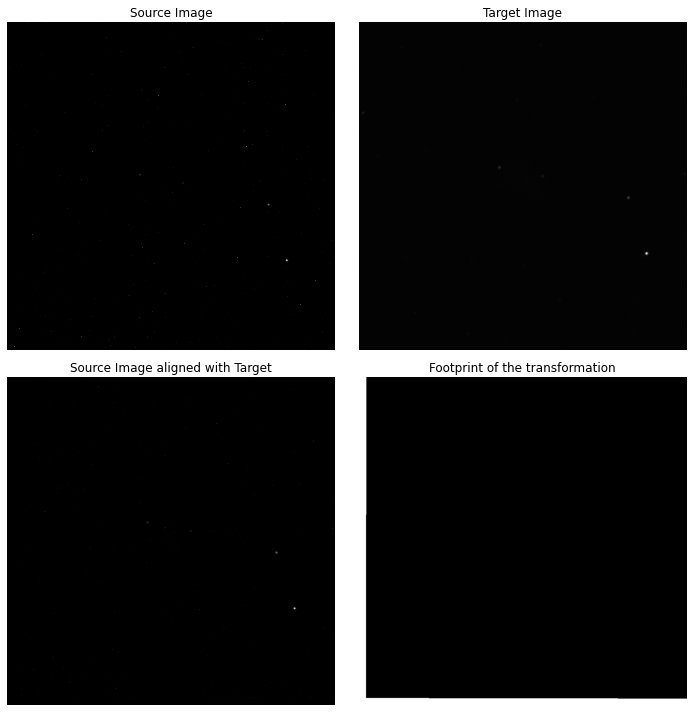

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(narrow_data, cmap='gray', interpolation='none'
, origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(broad_data, cmap='gray', #interpolation='none'
                   origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 0].imshow(aligned, cmap='gray', #interpolation='none'
                   origin='lower')
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Image aligned with Target")

axes[1, 1].imshow(footprint, cmap='gray', #interpolation='none'
                   origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint of the transformation")

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

madfactor = 275.0    mad_std =  7.11131497253858    threshold = 1955.6116174481094
0

1       301.07     897.46   14241.56  621966.83      43.67      95.00
2       475.44     840.78    3814.98  133730.11      35.05      46.00
3       569.62     438.35    2511.51   67844.09      27.01      30.00
0       301.07     897.46   14241.56  621966.83      43.67      95.00
1       475.44     840.78    3814.98  133730.11      35.05      46.00
2       569.62     438.35    2511.51   67844.09      27.01      30.00

0       301.07     897.46   14241.56  621966.83      43.67      95.00
1       475.44     840.78    3814.98  133730.11      35.05      46.00
2       569.62     438.35    2511.51   67844.09      27.01      30.00

count = 3
0       301.07     897.46   14241.56  621966.83      43.67      95.00
1       475.44     840.78    3814.98  133730.11      35.05      46.00
2       569.62     438.35    2511.51   67844.09      27.01      30.00
0       301.07     897.46   14241.56  621966.83      43.67    

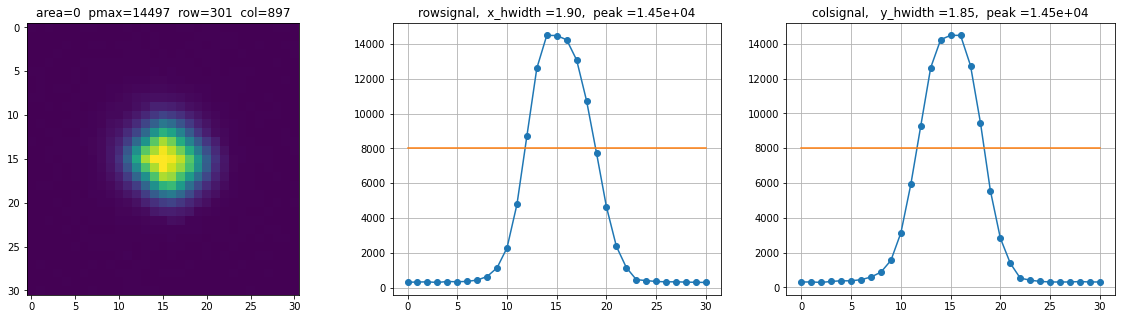

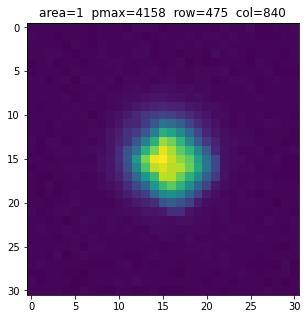

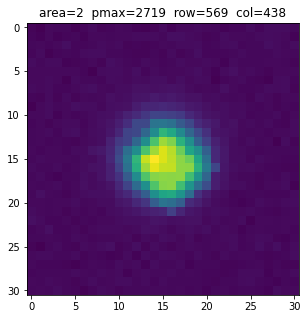

In [12]:
## Use the nd.label() function on a masked image to find bright stars.

img = broad_data.copy()           # Make a copy so you don't overwrite the original when you mask.
img = nd.median_filter(img,size=3)        # Median filter to remove single high pixels. Is it needed?
imgmed = np.nanmedian(img)               # Find the median.
imgmad = mad_std(img,ignore_nan=True)    # Find the median average deviation.

print('madfactor =',madfactor,'   mad_std = ',imgmad,'   threshold =', madfactor * imgmad)

llim = imgmad * madfactor
lmask = np.where(img < llim)
maskedimage = img.copy()
maskedimage[lmask] = 0.

image_to_label = maskedimage
image_in = image_to_label.copy()

## The nd.extrema function doesn't seem to like nans in the image.
## There may well be some in the borders of shifted images.
## So, first get rid of any.
anynans = np.where(np.isnan(image_in))  # Find any nans (e.g., ones generated when an image is shifted).
image_in[anynans] = imgmed              # Replace any nans with the image median.


labels, areas = nd.label(image_in)             # Function returns the array "labels" and the number of areas "areas".


## Find how many pixels are in each labeled area.
pixperarea = np.zeros((areas+1),dtype=int)             # Make an array to hold the number of pixels per area.
print( pixperarea[0])
print( '')

## Sum the values of pixels in area i. Divide by the values (equal to the label index) to get the number of pixels.
for i in range(1,areas+1):
    pixperarea[i] = nd.sum(labels,labels, index = i)/i
#     print( i, pixperarea[i])
# print( '')    

lpic = labels * 1.
#plt.figure(figsize = (8,8))
#plt.imshow(lpic,'gray_r', vmin = 0, vmax = 0.1, interpolation = 'nearest')

aparams = np.zeros((areas,6))
for i in range(1,areas+1):
    com = nd.center_of_mass(image_in, labels, index = i)  # Function returns (row,col) coordinates of center of mass.
#     ext = nd.extrema(image_in,labels, index = i)
    picmax = nd.maximum(image_in,labels, index = i)       # Function returns value of maximum pixel.
    picsum = nd.sum(image_in,labels, index = i)           # Function returns sum over pixels in area.
    ratio = picsum/picmax                                 # Small value may indicate isolated bad pixels (not stars).
    print ('{:<5}{:9.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}'.format(i,com[0],com[1],\
                                                                picmax,picsum,ratio,pixperarea[i]))

    aparams[i-1][0] = com[0]
    aparams[i-1][1] = com[1]
    aparams[i-1][2] = picmax
    aparams[i-1][3] = picsum
    aparams[i-1][4] = ratio
    aparams[i-1][5] = pixperarea[i]

## Cell to play with restricting the set obtained with nd.label() above.
for i in range(len(aparams)):
    print ('{:<5}{:9.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}'.format(i,aparams[i,0],aparams[i,1],aparams[i,2],\
                                                        aparams[i,3],aparams[i,4],aparams[i,5]))
print('')
count = 0
for i in range(len(aparams)):
    if aparams[i,5] > 25.:
        count += 1
        print ('{:<5}{:9.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}'.format(i,aparams[i,0],aparams[i,1],aparams[i,2],\
                                                        aparams[i,3],aparams[i,4],aparams[i,5]))
print('')
print('count =',count)

aparams_2 = np.zeros((count,6))
acopy = aparams.copy()
j = -1
for i in range(len(aparams)):
    if aparams[i,5] > 25.:
        j += 1
        aparams_2[j,:] = acopy[i,:]
        print('{:<5}{:9.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}'.format(i,aparams[i,0],aparams[i,1],aparams[i,2]
                                                                            ,aparams[i,3],aparams[i,4],aparams[i,5]))
for i in range(len(aparams_2)):
    print('{:<5}{:9.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}{:11.2f}'.format(i,aparams_2[i,0],aparams_2[i,1],aparams_2[i,2]
                                                                        , aparams_2[i,3],aparams_2[i,4],aparams_2[i,5]))
 
## Plot patches centered on areas found with nd.label().

whichimage = 0
img = broad_data.copy()
imgname = infilenames[whichimage]

whichareas = aparams
print('Number of areas =', whichareas.shape[0])


hw = (15,15)
threshold = 8000.
print('threshold =',threshold)
print('')

outarray = np.zeros((len(whichareas),6))

def moments(data):
    """Returns (height, x, y, halfwidth_x, halfwidth_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments."""
    total = np.nansum(data)
    Y, X = np.indices(data.shape)
#     print(Y)                       # Diagnostic.
#     print(X)                       # Diagnostic.
    x = np.nansum(X*data)/total
    y = np.nansum(Y*data)/total
    col = data[:, int(x)]
#     width_y = np.sqrt(np.nansum(np.abs(((np.arange(col.size)-y)**2)*col))/np.nansum(col))
    width_y = np.sqrt(np.nansum(((np.arange(col.size)-y)**2)*col)/np.nansum(col))           # Does't use abs().
    row = data[int(y), :]
#     width_x = np.sqrt(np.nansum(np.abs(((np.arange(row.size)-x)**2)*row))/np.nansum(row))
    width_x = np.sqrt(np.nansum(((np.arange(row.size)-x)**2)*row)/np.nansum(row))           # Does't use abs().
    height = data.max()
    return height, x, y, width_x, width_y

def getpatch(img,imgname,rowcenter,colcenter,hw,threshold=0,figlims=(20,5),patchname='',show=True):
    '''Plots subimage of img, prints some things, and returns some things.'''
    
    outs = (0,0,0,0,0)
    outs2 = (0,0,0,0,0)
    outs3 = -1
    patch = np.zeros((2*hw[0]+1,2*hw[1]+1))

    if rowcenter > hw[0] and colcenter > hw[1] and img.shape[0] - rowcenter > hw[0] and img.shape[1] - colcenter > hw[1]:

        patch = img[rowcenter-hw[0]:rowcenter+hw[0]+1,colcenter-hw[1]:colcenter+hw[1]+1].copy()
        patchmax = np.nanmax(patch)
        
        nanmask = np.isnan(patch)
        patch[nanmask] = -1e10
        nans = np.where(patch == -1e10)
        patch[nans] = 0.
        outs3 = len(nans[0])
        mask = np.where(patch < threshold)
        patch2 = patch.copy()
        patch2[mask] = 0.

        if show == True:
            plt.figure(figsize=figlims)
            print('row =',rowcenter,'   col =',colcenter)
            plt.subplot(1,3,1)
            plt.title('{}  pmax={:0.0f}  row={:d}  col={:d}'.format(patchname,patchmax,rowcenter,colcenter))
            plt.imshow(patch)
            print('number of nans =',len(nans[0]))
            if len(nans[0]) > 0:
                print('nans =',nans)
                print('')
                
        if patchmax > threshold:

            outs = moments(patch)
            outs2 = moments(patch2)
            psig, x, y, xw, yw = outs2

            if show == True:
                print(outs)
                print(outs2)

                rowsig = patch[int(y),:]
                rowpeak = np.max(rowsig)
                xrow = range(patch.shape[1])
                rowline = np.ones((patch.shape[1]))
                colsig = patch[:,int(x)]
                colpeak = np.max(colsig)
                xcol = range(patch.shape[0])
                colline = np.ones((patch.shape[0]))

                plt.subplot(1,3,2)
                plt.title('rowsignal,  x_hwidth ={:.2f},  peak ={:.2e}'.format(xw,rowpeak))
                plt.grid()
                plt.plot(xrow,rowsig, '-o')
                plt.plot(xrow,rowline * threshold)

                plt.subplot(1,3,3)
                plt.title('colsignal,   y_hwidth ={:.2f},  peak ={:.2e}'.format(yw,colpeak))
                plt.grid()
                plt.plot(xcol,colsig, '-o')
                plt.plot(xcol,colline * threshold)
                
            print('')
                
    else:
        print('The patch at row =',rowcenter,' and col=',colcenter,' is too close to the edge of the image.')
        print('')
        
    return patch, outs, outs2, outs3

for i in range(len(whichareas)):
    rowcenter, colcenter = int(whichareas[i,0]), int(whichareas[i,1])
    patchname = 'area={:d}'.format(i)
    print('area =',i)
    outputs = getpatch(img,imgname,rowcenter,colcenter,hw,threshold=threshold,patchname=patchname,figlims=(20,5),show=True)
    for j in range(5):
        outarray[i,j] = outputs[2][j]
    outarray[i,5] = outputs[3]

In [13]:
for i in range(len(aparams)):
    print(i, int(aparams[i,0]), int(aparams[i,1]))

flist = [0]                    # These are the "A list" stars. Bright, uncomplicated, faint, backgrounds.
rowarray = []
colarray = []
for i in flist:
    rowarray.append(int(aparams[i,0]))
    colarray.append(int(aparams[i,1]))
Amask = (rowarray,colarray)
print('Amask =',Amask)

flist = [1,2]                      # These are the "B and C list" stars. Bright, but with more complex backgrounds.
rowarray = []
colarray = []
for i in flist:
    rowarray.append(int(aparams[i,0]))
    colarray.append(int(aparams[i,1]))
Bmask = (rowarray,colarray)
print('Bmask =',Bmask)

flist = [0,1,2]              # These are the "A, B and C list" starsOn.
rowarray = []
colarray = []
for i in flist:
    rowarray.append(int(aparams[i,0]))
    colarray.append(int(aparams[i,1]))
Gmask = (rowarray,colarray)
print('Gmask =',Gmask)

0 301 897
1 475 840
2 569 438
Amask = ([301], [897])
Bmask = ([475, 569], [840, 438])
Gmask = ([301, 475, 569], [897, 840, 438])


Number of areas = 3
threshold = 8000.0

area = 0
row = 301    col = 897
number of nans = 0
(14497.17585336053, 15.27377501732597, 14.972739595343644, 3.7733177590837763, 3.6701119443868366)
(14497.17585336053, 15.451363528402466, 15.137048789811487, 1.8983459873742015, 1.8543027994709003)

area = 1
row = 475    col = 840
number of nans = 0
area = 2
row = 569    col = 438
number of nans = 0


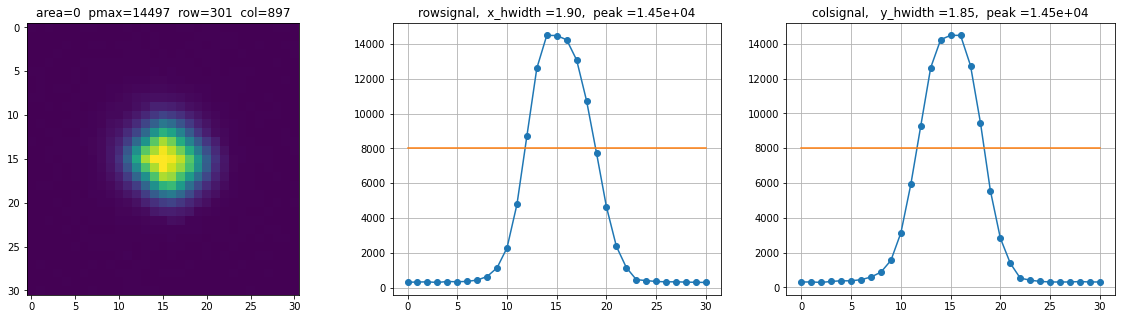

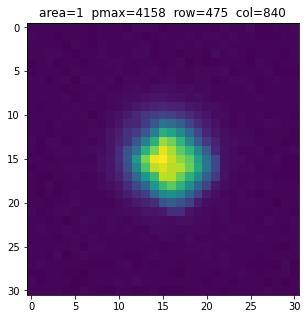

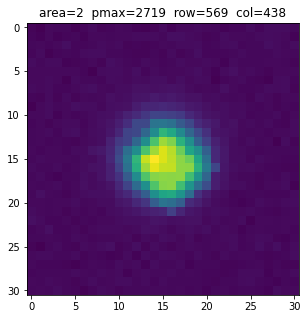

In [14]:
## Plot patches centered on "best" astrometry star candidates.

whichimage = 0
img = broad_data.copy()
imgname = infilenames[whichimage]

whichmask = Gmask
print('Number of areas =', len(whichmask[0]))

hw = (15,15)
threshold = 8000.
print('threshold =',threshold)
print('')

outarray = np.zeros((len(infilenames),len(whichmask[0]),6))

for i in range(len(whichmask[0])):
    rowcenter, colcenter = int(whichmask[0][i]), int(whichmask[1][i])
    patchname = 'area={:d}'.format(i)
    print('area =',i)
    outputs = getpatch(img,imgname,rowcenter,colcenter,hw,threshold=threshold,patchname=patchname,figlims=(20,5),show=True)
    for j in range(5):
        outarray[whichimage,i,j] = outputs[2][j]
    outarray[whichimage,i,5] = outputs[3]

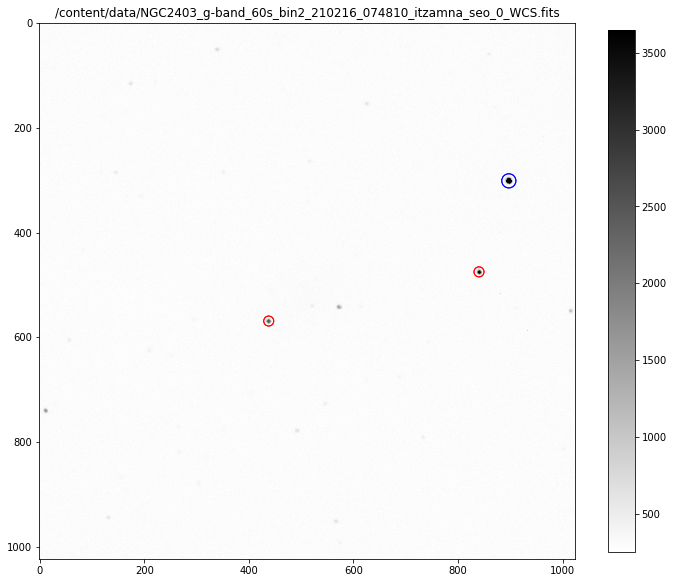

In [15]:
def quickpic(image,titlestring='',madfactor=(3.,10.),mask=([0],[0]),mask2=([0],[0]) ,csize=100,edgecolor='r',\
               edgecolor2='b', figlims=(10,10), negative=True, ilims=(0.,0.)):
    '''
    A simple image display tool with initial autoscaling based on image median and mad_std.
    It also includes the option to plot circles around positions defined in one or two image masks.
    image: A 2D image.
    titlestring: A text string for the figure title. Default is empty string.
    madfactor: A tuple with multipliers for mad_std to subtract or add to median to get vmin and vmax for imshow.
    mask: A tuple of ndarrays with lists of the row and column coordinates of the circles to plot.
    mask2: Another mask array for a second set of circles with twice the radius and different color.
    csize: Sets size of circles for mask positions. Circles for mask2 positions are two times larger.
    edgecolor: The color for the mask circles.
    edgecolor2: The color for the mask2 circles.
    figlims: Tuple to determine figsize.
    negative: =True (default) for black on white background and =False for white on black background.
    Al Harper created 190818.
    '''

    pic = image.copy()
    rows, cols = pic.shape
    med, mad = np.nanmedian(pic), mad_std(pic,ignore_nan=True)
    if ilims == (0.,0.):
        vmn, vmx = med - mad * madfactor[0], med + mad * madfactor[1]
    else:
        vmn, vmx = ilims
    plt.figure(figsize = (figlims))
    plt.title(titlestring)
    if negative == True:
        bw = 'gray_r'
    else: bw = 'gray'
    plt.imshow(pic, bw, interpolation='nearest', vmin = vmn, vmax = vmx)
    plt.colorbar(orientation = 'vertical',shrink = 0.8)
    for i in mask:
        if mask[0][0] != 0 and mask[1][0] != 0:
            plt.scatter(mask[1],mask[0],s=csize, facecolors='none', edgecolors=edgecolor)
        if mask2[0][0] != 0 and mask2[1][0] != 0:
            plt.scatter(mask2[1],mask2[0],s=2*csize, facecolors='none', edgecolors=edgecolor2)

quickpic(broad_data,infilenames[0],madfactor=(3.,200.),mask=Bmask,mask2=Amask,figlims=(12,12))

In [16]:
## nd.shift() has a problem with nans, so we need to find any in the image we want to shift
## and substitute something else at those pixels. Could be something like zero, but might be
## better to do something like take the median of the surrounding pixels.
tempimage = narrow_data.copy()
anynans = np.isnan(tempimage)
tempimage[anynans] = 1e-10
nans = np.where(tempimage == 1e-10)
tempimage[nans] = 0.
print('number of nans =',len(nans[0]))
print(nans)



number of nans = 0
(array([], dtype=int64), array([], dtype=int64))


In [17]:
def show_image(image,imagename,iy=100,ix=100,ydelta=100,xdelta=100,lims=(-100.,65536.,100.),linthresh=100.,linscale=0.3,\
       cursorcolors=('b','g'), starts=(3.,5.), steps = 1, plotgrid=False, whichcolor=['gray','gray_r','rainbow'],initcolor=1):
    '''Interactive display of single image.
    Inputs are:
    image-- a numpy array with dimensions (rows, columns).
    imagename-- a name string for the image to include in plot title, e.g., a filename.
    iy, ix-- row and column numbers for positions of cursor lines (horizontal, vertical).
    ydelta, xdelta-- displacements to second set of cursor lines.
    lims-- tuple with vmin, vmax, and step size for intensity scale. Note that if vmin is negative,
        LogNorm and PowerNorm may not work for some images).
    linthresh-- threshold parameter for SymLogNorm (sets range for the linear portion).
    linscale-- fraction of colorscale devoted to linear portion of SymLogNorm colorscale.
    cursorcolors-- tuple with colors of the two sets of cursors.
    starts-- tuple containing coefficients of mad_std for setting initial values of display intensity limits.
    steps-- size of steps in y and x for cursor positions.
    Outputs are:
    interactive image display.
    Area median-- the median of pixel values inside the area defined by the two cursor sets.
    Area std-- the standard deviation of pixel values inside the area defined by the cursor sets.
    Created by Al Harper, 180612.
    Al Harper modified 190311: Added 1 to ydelta and xdelta in the area integration so can integrate
    over entire image area. Note that this means the "bounded area" includes the cursor pixels.
    Al Harper modified 190318: Edit notes. Print out image median and mad_std. Add plotgrid True/False option.
    '''
    rows = image.shape[0]
    cols = image.shape[1]
    # Derive some scaling parameters.
    picmedian = np.nanmedian(image)
    picmad = mad_std(image,ignore_nan=True)
    lowstart = picmedian - starts[0]*picmad
    highstart = picmedian + starts[1]*picmad
    # An array of color scales for the interactive display slider.
    whichcolor = ['gray','gray_r','rainbow']
    def showpic(vmx=highstart,vmn=lowstart,iy=iy,ix=ix,ydelta=ydelta, xdelta=xdelta, scale=0, colorindex=initcolor):
        plt.figure(figsize = (14,14))
        if plotgrid == True:plt.grid()
        color= whichcolor[colorindex]
        print('colormap =',color)
        
        cx, cy = range(cols), range(rows)
        vx, vy, vdx, vdy = np.ones((rows)), np.ones((cols)), np.ones((rows)), np.ones((cols))
        vx, vy = ix * vx, iy * vy
        vdx, vdy = (ix + xdelta) * vdx, (iy + ydelta) * vdy

        plt.plot(cx,vy, cursorcolors[0], linewidth=0.4)    # Plot horizontal line at specified y value.,
        plt.plot(cx,vdy, cursorcolors[1], linewidth=0.4)   # Plot horizontal line at y + dy.
        plt.plot(vx,cy, cursorcolors[0], linewidth=0.4)    # Plot vertical line at specified x value.
        plt.plot(vdx,cy, cursorcolors[1], linewidth=0.4)   # Plot vertical line at x + dx.
        
        if scale == 0:
            whichscale = 'Scale = linear'
            plt.imshow(image, color, interpolation='nearest', vmin=vmn,vmax=vmx)
        if scale == 1:
            plt.imshow(image, color, interpolation='nearest', norm=LogNorm(vmin=vmn,vmax=vmx))
            whichscale = 'Scale = log'
        if scale == 2:
            plt.imshow(image, color, interpolation='nearest', norm=PowerNorm(gamma=0.5,vmin=vmn,vmax=vmx))
            whichscale = 'Scale = sqr_root'
        if scale == 3:
            vmin = -65535.
            plt.imshow(image, color, interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,\
                        linscale=linscale,vmin=vmn,vmax=vmx))
            whichscale = 'Scale = sym_log'
        print( 'Area median =',np.nanmedian(image[iy:iy+ydelta+1,ix:ix+xdelta+1]),\
        '   Area std =',np.nanstd(image[iy:iy+ydelta+1,ix:ix+xdelta+1]),\
        '   Area mad_std =',mad_std(image[iy:iy+ydelta+1,ix:ix+xdelta+1],ignore_nan=True))
        plt.title(imagename + '   ' + whichscale)
        plt.colorbar(orientation = 'vertical', shrink = 0.8)
        print('median =', picmedian,'   mad_std =',picmad)
    #     plt.scatter(ix,iy,s=80, facecolors='none', edgecolors='g')  # Positions a circular cursor at ix, iy.
    interact(showpic,vmx=(lims[0],lims[1],lims[2]),vmn=(lims[0], lims[1],lims[2]),iy=(0,rows-1,steps),\
             ix=(0,cols-1,steps),ydelta=(0,rows-1,steps),xdelta=(0,cols-1,steps),scale=(0,3,1),colorindex=(0,2,1))

In [18]:
whichfile = 1
basename = infilenames[whichfile][:-5]
outname = basename + 'sh.fits'
dy, dx = 20., 10.
outimage = nd.shift(tempimage,(dy, dx),cval = np.nan)   # Filling with nans means only common areas will be combined when stacked.
outd = fits.PrimaryHDU()
datapath = 'content/data/'
outf = os.path.join(datapath,outname)
outd.data = outimage
outd.header = bheader.copy()
outd.header['proctype'] = 'dark-subtracted, flat-fielded, shifted'
print( infilenames[whichfile])
print(outf)
# plt.imshow(outd.data,'gray_r')
outd.header

/content/data/NGC2403_h-alpha_120s_bin2_210216_062520_itzamna_seo_0_RAW.fits
/content/data/NGC2403_h-alpha_120s_bin2_210216_062520_itzamna_seo_0_RAWsh.fits


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DEWTEM1 =                  -20 / dewar temperature (C)                          
DETECTOR= 'ProLine_PL230'                                                       
DARKTIME=                   81 / time since last read (seconds)                 
XBIN    =                    2                                                  
YBIN    =                    2                                                  
PIXSIZE1=                   

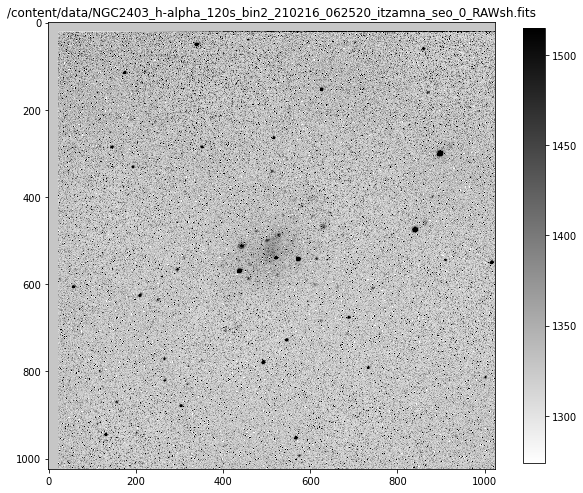

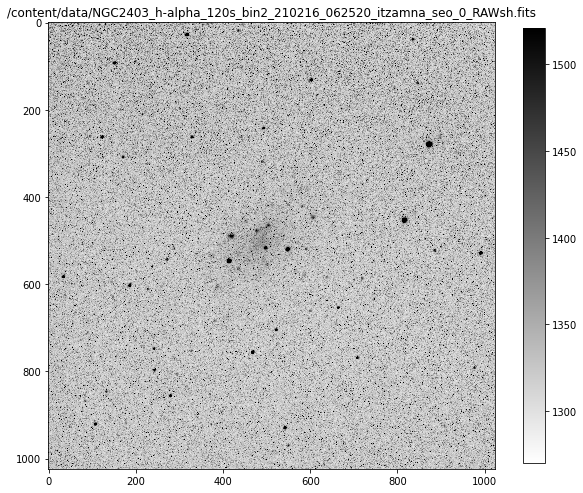

In [20]:
quickpic(aligned,outname)
quickpic(narrow_data,outname)

In [ ]:
## Now save the file (or not) using astropy.io.
print(outf)
yes_or_no = input('Save file? Enter "y" or "n":')
if yes_or_no == 'y':
    outd.writeto(outf, overwrite = False)
    print( outname + ' has been saved.')
else:
    print( 'OK-- file was not saved.')

/content/data/NGC2403_g-band_60s_bin2_210216_074810_itzamna_seo_0_WCSsh.fits
Save file? Enter "y" or "n":n
OK-- file was not saved.


In [ ]:
'''def drizzle_test(baseline, infile, outfile):
    # Get the world coordinate system for the output image
    baselist = fits.open(baseline)
    base_wcs = wcs.WCS(baselist[1].header)

    # Initialize the output with the wcs
    driz = drizzle.drizzle.Drizzle(outwcs=base_wcs)

    driz.add_image(infile.imgdata[0], base_wcs)

    driz.write(outfile)
    
def aa_test(broad, narrow):

    # open and extract data from fits files
    imbroad = open_seo_fits(broad)
    imnarrow = open_seo_fits(narrow)

    # initialize aligned image
    aligned, footprint = aa.find_transform(imbroad, imnarrow)

    return aligned, footprint
    '''

[[3.01095854e+02 8.97447075e+02 1.42415598e+04 5.72399128e+05
  4.01921655e+01 7.40000000e+01]
 [4.75473459e+02 8.40503924e+02 3.81497972e+03 8.17151802e+04
  2.14195582e+01 2.40000000e+01]]


'def drizzle_test(baseline, infile, outfile):\n    # Get the world coordinate system for the output image\n    baselist = fits.open(baseline)\n    base_wcs = wcs.WCS(baselist[1].header)\n\n    # Initialize the output with the wcs\n    driz = drizzle.drizzle.Drizzle(outwcs=base_wcs)\n\n    driz.add_image(infile.imgdata[0], base_wcs)\n\n    driz.write(outfile)\n    \ndef aa_test(broad, narrow):\n\n    # open and extract data from fits files\n    imbroad = open_seo_fits(broad)\n    imnarrow = open_seo_fits(narrow)\n\n    # initialize aligned image\n    aligned, footprint = aa.find_transform(imbroad, imnarrow)\n\n    return aligned, footprint\n    '